# Latent Representations
## Preamble

In [1]:
%matplotlib notebook
%load_ext autoreload 
%autoreload 2

import os
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import IPython.display as ipd
import matplotlib.ticker as ticker

from pathlib import Path
import numpy as np

import torch.utils.data.dataloader

import src.models.predict_model as predict
import src.data.load_dataset
import src.data.make_dataset

from src.config.load_config import load_config
from src.visualization.visualize import animate_signal_pairs
from src.common import merge_into_flat_one

plt.rcParams['animation.ffmpeg_path'] = 'ffmpeg'

project_dir = Path(predict.__file__).resolve().parents[2]
os.chdir(project_dir)


## Phase
### Create Custom, Non-Random Data

Phase will vary, and nothing else.

In [2]:
data_path = Path('data/processed')
experiment_cfg_path = Path('config/experiment.json')
data_cfg_path = Path('config/data_generator.json')

# config loader
cfg = load_config(experiment_cfg_path) 
cfg_data = load_config(data_cfg_path)
N = 500

amplitudes = np.mean(cfg_data['amplitude_range'])
frequencies = np.mean(cfg_data['frequency_range'])
phases = np.linspace(cfg_data['phase_range'][0],cfg_data['phase_range'][1],N)[:,None]

# data loader
t, sinusoids = src.data.make_dataset.generate_sinusoids(frequencies, amplitudes, phases, **cfg_data)
test_dataset = src.data.load_dataset.OnTheFlyDataset(sinusoids)
test_loader = torch.utils.data.dataloader.DataLoader(dataset=test_dataset, **cfg['test_loader'])

# model
model_save_name = "{}_{}".format(cfg['experiment']['name'], cfg['model']['name'])
model_save_path = project_dir / cfg['model']['path'] / model_save_name 
print(model_save_path)

/home/ege/Documents/ThesisExperiment/toy_vae_example/models/epoch_10_batch_50_asym_nobo_vae_3layer_relu.pt


### Run Inference

In [3]:
predictor = predict.Prediction(cfg['model'], model_save_path, **cfg['training'])
results = predictor.predict(test_loader)
results_latent = predictor.to_latent_space(test_loader)



### Display Input & Output Together

<IPython.core.display.Javascript object>


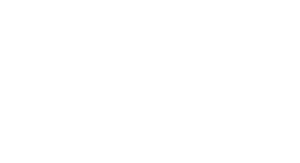

500 (100,) (500, 100)
500 (100,) (500, 100)


In [4]:
inputs = [x.numpy() for x in test_loader]
inputs, results = np.concatenate(inputs, axis=0), np.concatenate(results, axis=0)
inputs = np.reshape(inputs, (N, -1))
results = np.reshape(results, (N, -1))

anim = animate_signal_pairs(t, inputs, results)
video = anim.to_html5_video()
html = ipd.HTML(video)
ipd.display(html)


## Amplitude (not learned)

### Generate data

In [5]:
amplitudes = np.linspace(-cfg_data['amplitude_range'][0],cfg_data['amplitude_range'][1],N)[:,None]
frequencies = np.mean(cfg_data['frequency_range'])
phase = np.zeros_like(amplitudes)
phase[:N//2] = -np.pi/4
phase[N//2] = np.pi/4

# data loader
t, sinusoids = src.data.make_dataset.generate_sinusoids(frequencies, amplitudes, phase, **cfg_data)
test_dataset = src.data.load_dataset.OnTheFlyDataset(sinusoids)
test_loader = torch.utils.data.dataloader.DataLoader(dataset=test_dataset, **cfg['test_loader'])

### Inference

In [6]:
predictor = predict.Prediction(cfg['model'], model_save_path, **cfg['training'])
results = predictor.predict(test_loader)
results_latent = predictor.to_latent_space(test_loader)

### Display I&O

500 (2,) (500, 2)
(500, 2) 2 (400, 100)


<IPython.core.display.Javascript object>


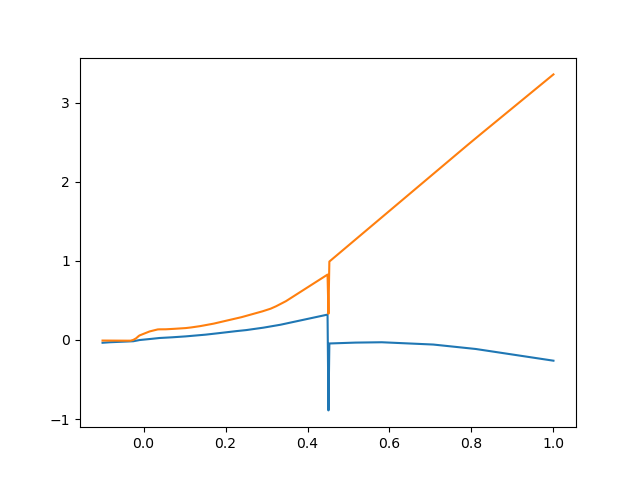

<IPython.core.display.Javascript object>


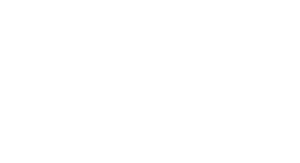

500 (100,) (500, 100)
500 (100,) (500, 100)


In [7]:

latent = np.concatenate(results_latent, axis=0)
latent = merge_into_flat_one(latent).reshape((N,-1))
print(latent.shape, len(results), results[0].shape)
plt.figure()
ax = plt.axes()
for i in range(len(latent[0])):
    plt.plot(amplitudes, latent[:,i])
plt.show()

inputs = [x.numpy() for x in test_loader]
inputs, results = np.concatenate(inputs, axis=0), np.concatenate(results, axis=0)
inputs = np.reshape(inputs, (N, -1))
results = np.reshape(results, (N, -1))

anim = animate_signal_pairs(t, inputs, results)
video = anim.to_html5_video()
html = ipd.HTML(video)
ipd.display(html)


## Explore Learned Representation against Amplitude

In [8]:
N

500